In [6]:
from filtering_dataset import FilteringDataset
from torchvision import transforms

train_transform = transforms.Compose([
    #transforms.RandomRotation(degrees=30), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # PIL -> Tensor and [0,255] -> [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std of 0.5
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  # PIL -> Tensor and [0,255] -> [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std of 0.5
])

train_dir_clean = '/projectnb/npbssmic/ac25/Annotation_Filtering/defect_filtering_dataset/train/Clean'
train_dir_unclean = '/projectnb/npbssmic/ac25/Annotation_Filtering/defect_filtering_dataset/train/Unclean'  
train_dataset = FilteringDataset(clean_dir=train_dir_clean, unclean_dir=train_dir_unclean, transform=train_transform)

val_dir_clean = '/projectnb/npbssmic/ac25/Annotation_Filtering/defect_filtering_dataset/valid/Clean'
val_dir_unclean = '/projectnb/npbssmic/ac25/Annotation_Filtering/defect_filtering_dataset/valid/Unclean' 
val_dataset = FilteringDataset(clean_dir=val_dir_clean, unclean_dir=val_dir_unclean, transform=val_transform)

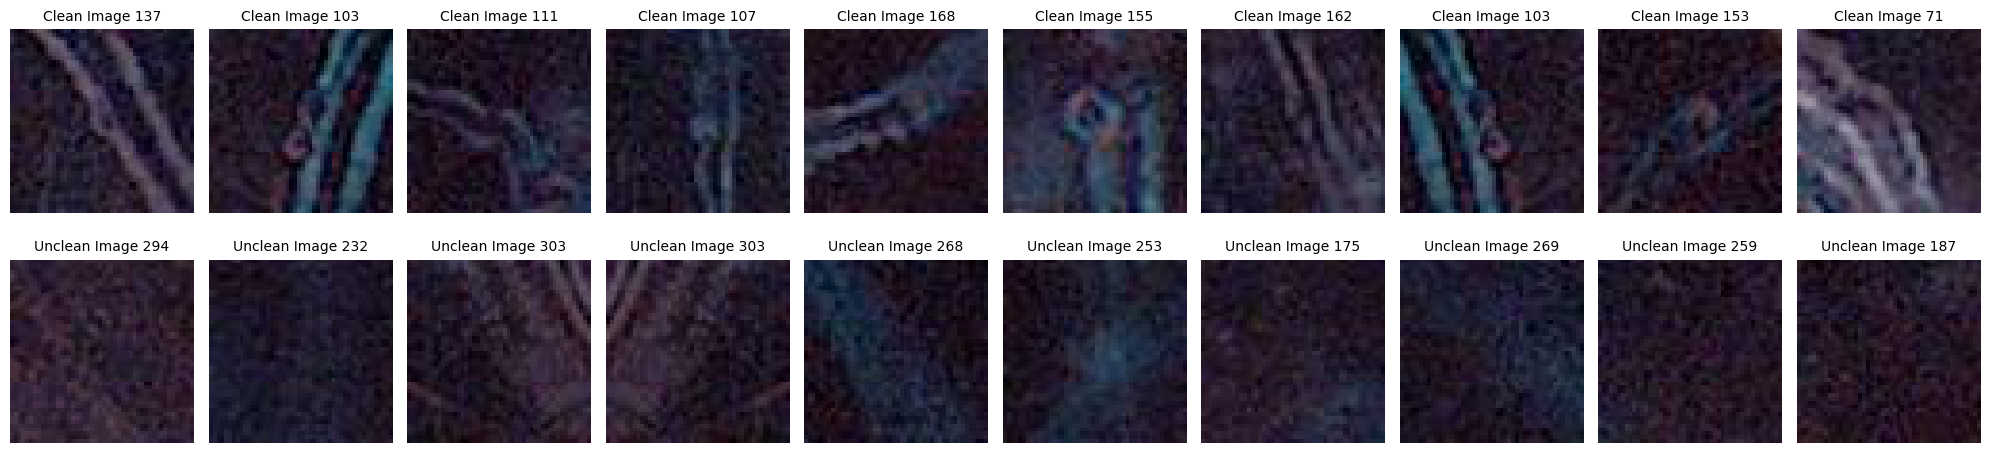

In [7]:
import random
import matplotlib.pyplot as plt

# Number of images to display per category (clean/unclean)
num_images = 10
fig, axs = plt.subplots(2, num_images, figsize=(20, 5))

# Show clean images (label 0)
clean_images = [i for i in range(len(train_dataset)) if train_dataset[i][1] == 0]  # Indices for clean images
for i in range(num_images):
    idx = random.choice(clean_images)  # Randomly pick a clean image index
    image_example, label = train_dataset[idx]
    
    # Convert the tensor back to image format
    image_example = image_example.numpy().transpose(1, 2, 0)
    image_example = ((image_example * 0.5) + 0.5) * 255  # Undo normalization
    image_example = image_example.astype('uint8')

    axs[0, i].imshow(image_example, interpolation='nearest')
    axs[0, i].set_title(f'Clean Image {idx}', fontsize=10)
    axs[0, i].axis('off')

# Show unclean images (label 1)
unclean_images = [i for i in range(len(train_dataset)) if train_dataset[i][1] == 1]  # Indices for unclean images
for i in range(num_images):
    idx = random.choice(unclean_images)  # Randomly pick an unclean image index
    image_example, label = train_dataset[idx]
    
    # Convert the tensor back to image format
    image_example = image_example.numpy().transpose(1, 2, 0)
    image_example = ((image_example * 0.5) + 0.5) * 255  # Undo normalization
    image_example = image_example.astype('uint8')

    axs[1, i].imshow(image_example, interpolation='nearest')
    axs[1, i].set_title(f'Unclean Image {idx}', fontsize=10)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Create data loaders
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [15]:
# Instantiate model 
from cnn import FilteringCNN

cnn = FilteringCNN(input_size=48, input_channels=3)  
print(cnn)

FilteringCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9216, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

device = "cpu"
cnn = cnn.to(device)  
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

# Training loop parameters
num_epochs = 60
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

#if output > threshold -> 1, else 0
threshold = 0.5

# Training loop
for epoch in tqdm(range(num_epochs)):
    cnn.train()  # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)  
        labels = labels.to(device).float().unsqueeze(1)
        
        outputs = cnn(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss for binary classification
    
        optimizer.zero_grad()  # Zero out gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights
        
        running_train_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs > threshold).float()  # Binarize the outputs
        correct_train += (predicted == labels).sum().item()  # Count correct predictions
        total_train += labels.size(0)  # Count total examples
    
    # Calculate training loss and accuracy
    train_loss.append(running_train_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)  # Store training accuracy

    cnn.eval()  # Set model to evaluation mode for validation
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)
            
            val_outputs = cnn(val_images)  # Forward pass for validation
            v_loss = criterion(val_outputs, val_labels)  # Validation loss
            running_val_loss += v_loss.item()
            
            # Calculate validation accuracy
            val_predicted = (val_outputs > threshold).float()  # Binarize the outputs
            correct_val += (val_predicted == val_labels).sum().item()  # Count correct predictions
            total_val += val_labels.size(0)  # Count total examples
    
    # Calculate validation loss and accuracy
    val_loss.append(running_val_loss / len(val_loader))
    val_accuracy.append(correct_val / total_val)  # Store validation accuracy
    
    # Display progress
    tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}, '
                f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}')

print('Finished training')


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:00<00:23,  2.49it/s]

Epoch [1/60], Train Loss: 0.6900, Train Accuracy: 0.5031, Val Loss: 0.6830, Val Accuracy: 0.6625


  3%|▎         | 2/60 [00:00<00:22,  2.59it/s]

Epoch [2/60], Train Loss: 0.6733, Train Accuracy: 0.5625, Val Loss: 0.6714, Val Accuracy: 0.4250


  5%|▌         | 3/60 [00:01<00:21,  2.63it/s]

Epoch [3/60], Train Loss: 0.6308, Train Accuracy: 0.6438, Val Loss: 0.6055, Val Accuracy: 0.8375


  7%|▋         | 4/60 [00:01<00:21,  2.62it/s]

Epoch [4/60], Train Loss: 0.6271, Train Accuracy: 0.6125, Val Loss: 0.5973, Val Accuracy: 0.7500


  8%|▊         | 5/60 [00:01<00:21,  2.62it/s]

Epoch [5/60], Train Loss: 0.5225, Train Accuracy: 0.7750, Val Loss: 0.4524, Val Accuracy: 0.8500


 10%|█         | 6/60 [00:02<00:20,  2.63it/s]

Epoch [6/60], Train Loss: 0.4749, Train Accuracy: 0.7594, Val Loss: 0.3983, Val Accuracy: 0.8625


 12%|█▏        | 7/60 [00:02<00:20,  2.63it/s]

Epoch [7/60], Train Loss: 0.4059, Train Accuracy: 0.8469, Val Loss: 0.4309, Val Accuracy: 0.8625


 13%|█▎        | 8/60 [00:03<00:19,  2.61it/s]

Epoch [8/60], Train Loss: 0.3195, Train Accuracy: 0.9187, Val Loss: 0.3138, Val Accuracy: 0.9250


 15%|█▌        | 9/60 [00:03<00:19,  2.62it/s]

Epoch [9/60], Train Loss: 0.3004, Train Accuracy: 0.8750, Val Loss: 0.2987, Val Accuracy: 0.9125


 17%|█▋        | 10/60 [00:03<00:19,  2.63it/s]

Epoch [10/60], Train Loss: 0.2484, Train Accuracy: 0.9156, Val Loss: 0.3004, Val Accuracy: 0.9500


 18%|█▊        | 11/60 [00:04<00:18,  2.61it/s]

Epoch [11/60], Train Loss: 0.2147, Train Accuracy: 0.9625, Val Loss: 0.1604, Val Accuracy: 0.9500


 20%|██        | 12/60 [00:04<00:18,  2.60it/s]

Epoch [12/60], Train Loss: 0.1823, Train Accuracy: 0.9531, Val Loss: 0.1662, Val Accuracy: 0.9500


 22%|██▏       | 13/60 [00:04<00:17,  2.63it/s]

Epoch [13/60], Train Loss: 0.1415, Train Accuracy: 0.9750, Val Loss: 0.1476, Val Accuracy: 0.9625


 23%|██▎       | 14/60 [00:05<00:17,  2.59it/s]

Epoch [14/60], Train Loss: 0.1711, Train Accuracy: 0.9406, Val Loss: 0.2106, Val Accuracy: 0.9500


 25%|██▌       | 15/60 [00:05<00:17,  2.62it/s]

Epoch [15/60], Train Loss: 0.1345, Train Accuracy: 0.9531, Val Loss: 0.1944, Val Accuracy: 0.9625


 27%|██▋       | 16/60 [00:06<00:16,  2.61it/s]

Epoch [16/60], Train Loss: 0.1225, Train Accuracy: 0.9688, Val Loss: 0.0958, Val Accuracy: 0.9750


 28%|██▊       | 17/60 [00:06<00:16,  2.61it/s]

Epoch [17/60], Train Loss: 0.1220, Train Accuracy: 0.9688, Val Loss: 0.1415, Val Accuracy: 0.9500


 30%|███       | 18/60 [00:06<00:16,  2.56it/s]

Epoch [18/60], Train Loss: 0.0986, Train Accuracy: 0.9750, Val Loss: 0.0923, Val Accuracy: 0.9750


 32%|███▏      | 19/60 [00:07<00:15,  2.57it/s]

Epoch [19/60], Train Loss: 0.1012, Train Accuracy: 0.9625, Val Loss: 0.0706, Val Accuracy: 0.9875


 33%|███▎      | 20/60 [00:07<00:15,  2.58it/s]

Epoch [20/60], Train Loss: 0.1648, Train Accuracy: 0.9437, Val Loss: 0.3623, Val Accuracy: 0.8500


 35%|███▌      | 21/60 [00:08<00:15,  2.56it/s]

Epoch [21/60], Train Loss: 0.1267, Train Accuracy: 0.9625, Val Loss: 0.0942, Val Accuracy: 0.9875


 37%|███▋      | 22/60 [00:08<00:14,  2.59it/s]

Epoch [22/60], Train Loss: 0.1091, Train Accuracy: 0.9594, Val Loss: 0.0786, Val Accuracy: 1.0000


 38%|███▊      | 23/60 [00:08<00:14,  2.49it/s]

Epoch [23/60], Train Loss: 0.0812, Train Accuracy: 0.9750, Val Loss: 0.0692, Val Accuracy: 0.9750


 40%|████      | 24/60 [00:09<00:14,  2.55it/s]

Epoch [24/60], Train Loss: 0.0918, Train Accuracy: 0.9656, Val Loss: 0.1017, Val Accuracy: 0.9500


 42%|████▏     | 25/60 [00:09<00:13,  2.56it/s]

Epoch [25/60], Train Loss: 0.0828, Train Accuracy: 0.9719, Val Loss: 0.0739, Val Accuracy: 0.9875


 43%|████▎     | 26/60 [00:10<00:13,  2.57it/s]

Epoch [26/60], Train Loss: 0.0741, Train Accuracy: 0.9844, Val Loss: 0.0553, Val Accuracy: 1.0000


 45%|████▌     | 27/60 [00:10<00:12,  2.54it/s]

Epoch [27/60], Train Loss: 0.0618, Train Accuracy: 0.9875, Val Loss: 0.0671, Val Accuracy: 1.0000


 47%|████▋     | 28/60 [00:10<00:12,  2.58it/s]

Epoch [28/60], Train Loss: 0.0825, Train Accuracy: 0.9719, Val Loss: 0.1659, Val Accuracy: 0.9375


 48%|████▊     | 29/60 [00:11<00:11,  2.60it/s]

Epoch [29/60], Train Loss: 0.0668, Train Accuracy: 0.9750, Val Loss: 0.0457, Val Accuracy: 0.9875


 50%|█████     | 30/60 [00:11<00:11,  2.62it/s]

Epoch [30/60], Train Loss: 0.0529, Train Accuracy: 0.9875, Val Loss: 0.0453, Val Accuracy: 0.9750


 52%|█████▏    | 31/60 [00:11<00:10,  2.64it/s]

Epoch [31/60], Train Loss: 0.0663, Train Accuracy: 0.9781, Val Loss: 0.1038, Val Accuracy: 0.9375


 53%|█████▎    | 32/60 [00:12<00:10,  2.63it/s]

Epoch [32/60], Train Loss: 0.0610, Train Accuracy: 0.9812, Val Loss: 0.0438, Val Accuracy: 0.9875


 55%|█████▌    | 33/60 [00:12<00:10,  2.61it/s]

Epoch [33/60], Train Loss: 0.0621, Train Accuracy: 0.9688, Val Loss: 0.0772, Val Accuracy: 0.9625


 57%|█████▋    | 34/60 [00:13<00:10,  2.60it/s]

Epoch [34/60], Train Loss: 0.0723, Train Accuracy: 0.9719, Val Loss: 0.0388, Val Accuracy: 1.0000


 58%|█████▊    | 35/60 [00:13<00:09,  2.60it/s]

Epoch [35/60], Train Loss: 0.0674, Train Accuracy: 0.9781, Val Loss: 0.0489, Val Accuracy: 1.0000


 60%|██████    | 36/60 [00:13<00:09,  2.61it/s]

Epoch [36/60], Train Loss: 0.0626, Train Accuracy: 0.9812, Val Loss: 0.0433, Val Accuracy: 1.0000


 62%|██████▏   | 37/60 [00:14<00:08,  2.60it/s]

Epoch [37/60], Train Loss: 0.0454, Train Accuracy: 0.9875, Val Loss: 0.0838, Val Accuracy: 0.9500


 63%|██████▎   | 38/60 [00:14<00:08,  2.58it/s]

Epoch [38/60], Train Loss: 0.0445, Train Accuracy: 0.9906, Val Loss: 0.0439, Val Accuracy: 0.9875


 65%|██████▌   | 39/60 [00:15<00:08,  2.45it/s]

Epoch [39/60], Train Loss: 0.0444, Train Accuracy: 0.9906, Val Loss: 0.0836, Val Accuracy: 0.9500


 67%|██████▋   | 40/60 [00:15<00:08,  2.39it/s]

Epoch [40/60], Train Loss: 0.0587, Train Accuracy: 0.9750, Val Loss: 0.0425, Val Accuracy: 0.9875


 68%|██████▊   | 41/60 [00:15<00:08,  2.37it/s]

Epoch [41/60], Train Loss: 0.0511, Train Accuracy: 0.9906, Val Loss: 0.0434, Val Accuracy: 0.9875


 70%|███████   | 42/60 [00:16<00:07,  2.36it/s]

Epoch [42/60], Train Loss: 0.0445, Train Accuracy: 0.9875, Val Loss: 0.0331, Val Accuracy: 1.0000


 72%|███████▏  | 43/60 [00:16<00:07,  2.42it/s]

Epoch [43/60], Train Loss: 0.0413, Train Accuracy: 0.9875, Val Loss: 0.0355, Val Accuracy: 1.0000


 73%|███████▎  | 44/60 [00:17<00:06,  2.35it/s]

Epoch [44/60], Train Loss: 0.0509, Train Accuracy: 0.9750, Val Loss: 0.1157, Val Accuracy: 0.9375


 75%|███████▌  | 45/60 [00:17<00:06,  2.38it/s]

Epoch [45/60], Train Loss: 0.0418, Train Accuracy: 0.9875, Val Loss: 0.0591, Val Accuracy: 1.0000


 77%|███████▋  | 46/60 [00:18<00:06,  2.32it/s]

Epoch [46/60], Train Loss: 0.0472, Train Accuracy: 0.9844, Val Loss: 0.0279, Val Accuracy: 0.9875


 78%|███████▊  | 47/60 [00:18<00:05,  2.34it/s]

Epoch [47/60], Train Loss: 0.0412, Train Accuracy: 0.9844, Val Loss: 0.0289, Val Accuracy: 0.9875


 80%|████████  | 48/60 [00:18<00:05,  2.34it/s]

Epoch [48/60], Train Loss: 0.0327, Train Accuracy: 0.9938, Val Loss: 0.0420, Val Accuracy: 0.9875


 82%|████████▏ | 49/60 [00:19<00:04,  2.36it/s]

Epoch [49/60], Train Loss: 0.0432, Train Accuracy: 0.9875, Val Loss: 0.0317, Val Accuracy: 0.9875


 83%|████████▎ | 50/60 [00:19<00:04,  2.39it/s]

Epoch [50/60], Train Loss: 0.0574, Train Accuracy: 0.9781, Val Loss: 0.0934, Val Accuracy: 0.9500


 85%|████████▌ | 51/60 [00:20<00:03,  2.35it/s]

Epoch [51/60], Train Loss: 0.0419, Train Accuracy: 0.9875, Val Loss: 0.0279, Val Accuracy: 0.9875


 87%|████████▋ | 52/60 [00:20<00:03,  2.36it/s]

Epoch [52/60], Train Loss: 0.0237, Train Accuracy: 0.9969, Val Loss: 0.0717, Val Accuracy: 0.9625


 88%|████████▊ | 53/60 [00:21<00:02,  2.36it/s]

Epoch [53/60], Train Loss: 0.0281, Train Accuracy: 0.9906, Val Loss: 0.0380, Val Accuracy: 0.9875


 90%|█████████ | 54/60 [00:21<00:02,  2.41it/s]

Epoch [54/60], Train Loss: 0.0172, Train Accuracy: 1.0000, Val Loss: 0.0302, Val Accuracy: 0.9875


 92%|█████████▏| 55/60 [00:21<00:02,  2.41it/s]

Epoch [55/60], Train Loss: 0.0383, Train Accuracy: 0.9906, Val Loss: 0.0628, Val Accuracy: 0.9750


 93%|█████████▎| 56/60 [00:22<00:01,  2.41it/s]

Epoch [56/60], Train Loss: 0.0656, Train Accuracy: 0.9719, Val Loss: 0.0564, Val Accuracy: 0.9875


 95%|█████████▌| 57/60 [00:22<00:01,  2.42it/s]

Epoch [57/60], Train Loss: 0.0665, Train Accuracy: 0.9719, Val Loss: 0.0853, Val Accuracy: 0.9500


 97%|█████████▋| 58/60 [00:23<00:00,  2.40it/s]

Epoch [58/60], Train Loss: 0.0557, Train Accuracy: 0.9781, Val Loss: 0.0816, Val Accuracy: 0.9875


 98%|█████████▊| 59/60 [00:23<00:00,  2.43it/s]

Epoch [59/60], Train Loss: 0.0362, Train Accuracy: 0.9906, Val Loss: 0.0377, Val Accuracy: 1.0000


100%|██████████| 60/60 [00:23<00:00,  2.50it/s]

Epoch [60/60], Train Loss: 0.0209, Train Accuracy: 1.0000, Val Loss: 0.0682, Val Accuracy: 0.9500
Finished training


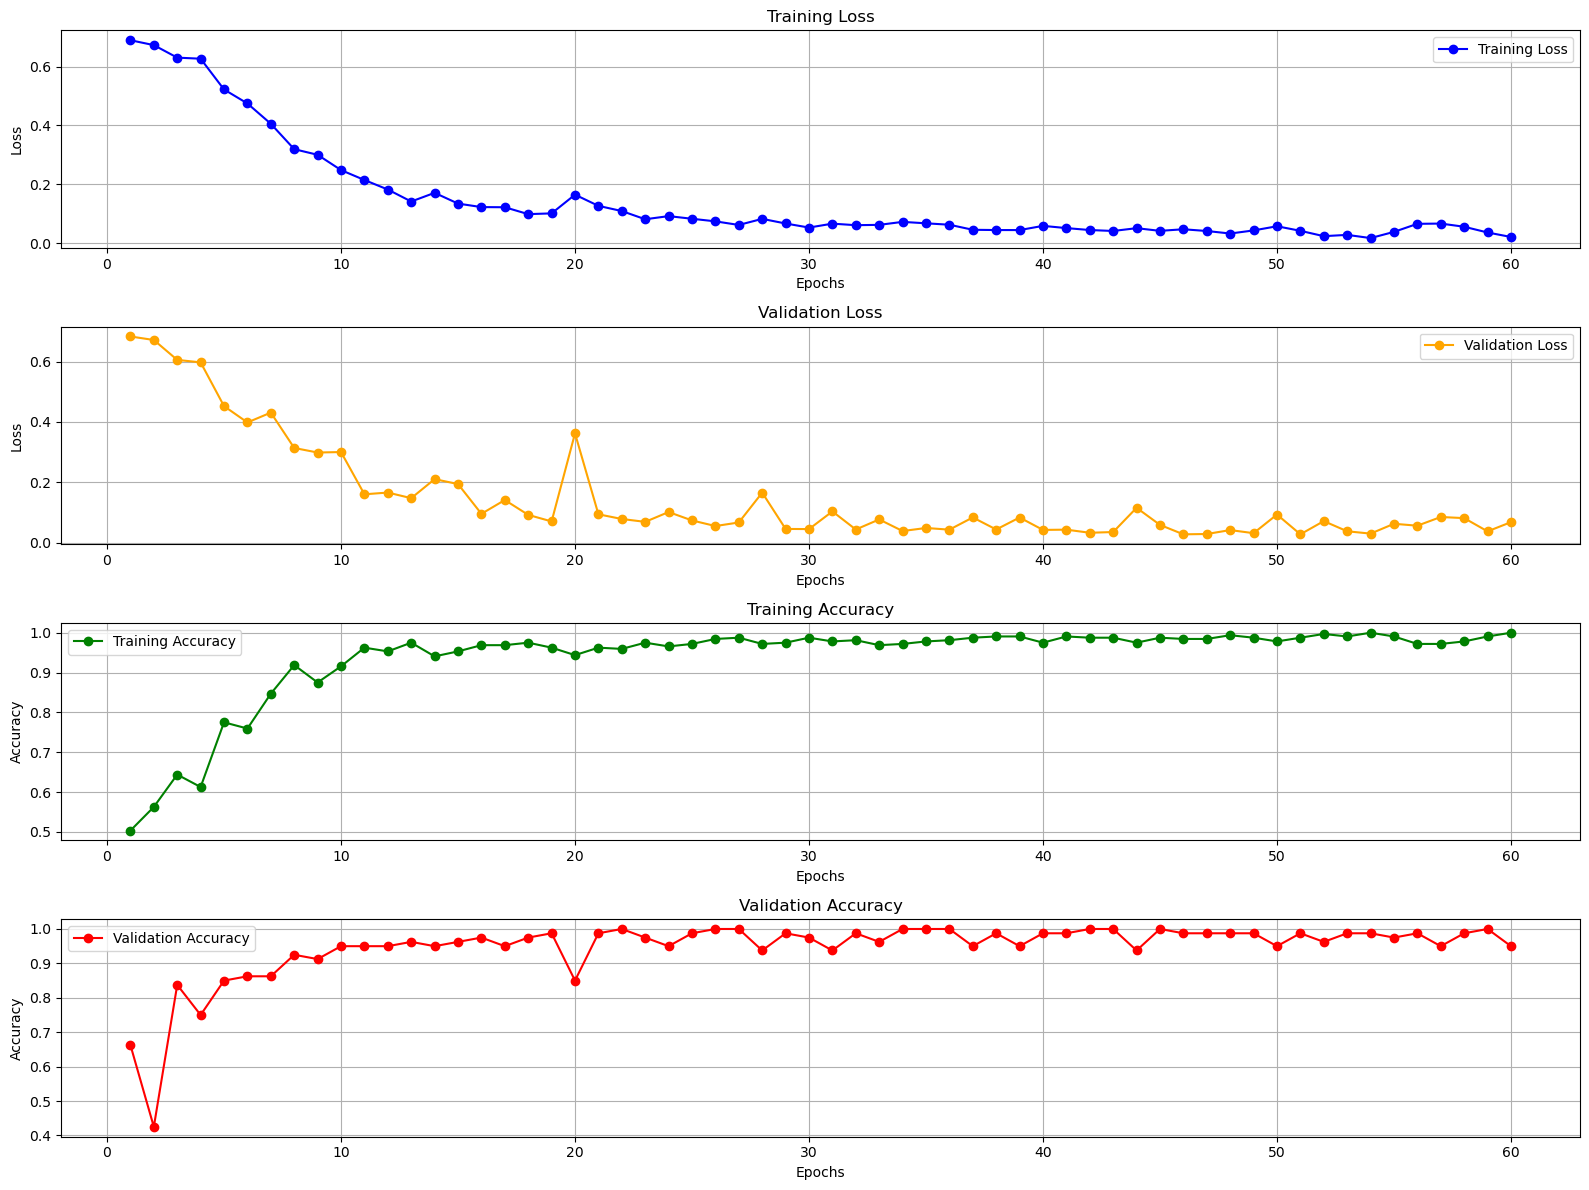

In [21]:
import matplotlib.pyplot as plt

# Prepare the epochs list for plotting
epochs = list(range(1, num_epochs + 1))

# Create a 4x4 subplot
fig, axs = plt.subplots(4, 1, figsize=(16, 12))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Plotting training loss
axs[0].plot(epochs, train_loss, label='Training Loss', marker='o', color='blue')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plotting validation loss
axs[1].plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plotting training accuracy
axs[2].plot(epochs, train_accuracy, label='Training Accuracy', marker='o', color='green')
axs[2].set_title('Training Accuracy')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()
axs[2].grid(True)

# Plotting validation accuracy
axs[3].plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='red')
axs[3].set_title('Validation Accuracy')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Accuracy')
axs[3].legend()
axs[3].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


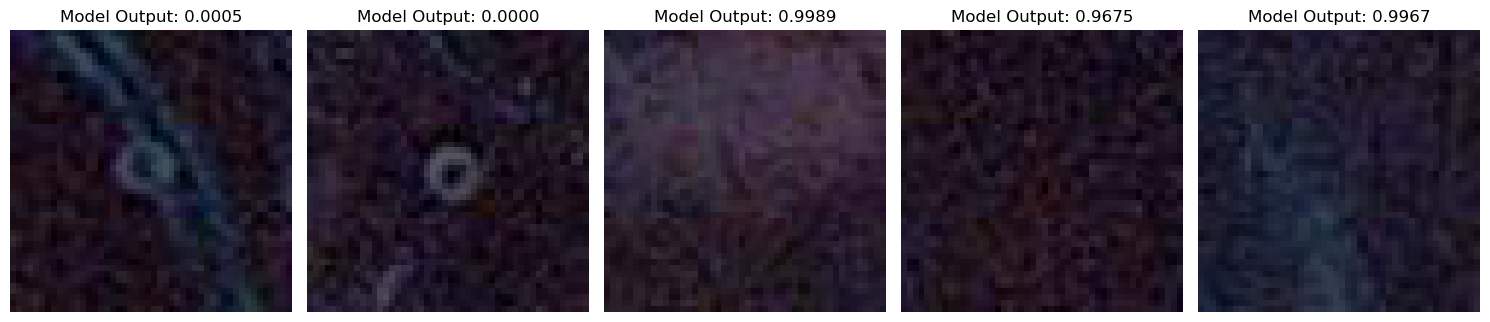

In [23]:
import random
import matplotlib.pyplot as plt

# Set the model to evaluation mode
cnn.eval()

# Get 5 random images from the validation dataset
num_images = 5
indices = random.sample(range(len(val_dataset)), num_images)

# Prepare subplots
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, idx in enumerate(indices):
    # Get the image from the validation dataset
    val_image, _ = val_dataset[idx]  # Only get the image, ignore the label
    val_image = val_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Forward pass through the model
    with torch.no_grad():
        output = cnn(val_image)  # Get model output

    # Move image back to CPU and convert to numpy for plotting
    img_np = val_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    img_np = ((img_np * 0.5) + 0.5) * 255  # Denormalize to [0, 255]
    img_np = img_np.astype('uint8')

    # Display image and model output
    axs[i].imshow(img_np)
    axs[i].set_title(f'Model Output: {output.item():.4f}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [25]:
save_path = '/projectnb/npbssmic/ac25/Annotation_Filtering/model.pt'
torch.save(cnn.state_dict(), save_path)